In [6]:
import numpy as np
import math
from matplotlib import pyplot as pp
import mdtraj as md
import pandas as pd

# Effective Sample Size (Lyman & Zuckerman, J Phys Chem, 2007)
### Effective sample size is the number of statistically independent samples.
* Inputs: a trajectory of interest, number of subsample (n), initial interval between the subsamples (t), number of bins to generate a structural histogram (S)
* output: 
    - a graph of variance vs timestep
    - Decorrelation time
    - effective sample size
    - a structural histogram
 
 ** Note: The number of bins selected must be a factor of the total number of frames to satisfy uniform probability.

* Other parameters:
    - f : uniform probability for binning structures
    - l : fxN, number of frames to put in each bin

In [189]:
class EffectiveSampleSize:
    def __init__(self, trajectory, timestep, n, t, S):
        self.traj = md.load(trajectory)
        self.n = n
        self.t = t
        self.S = S
        self.N = self.traj.n_frames
        self.f = 1/self.S
        self.l = int(self.f * self.N)
        self.timestep = timestep
    
    def analyze_variance(self):
        traj = self.traj
        f = self.f
        n = self.n
        t = self.t
        S = self.S
        N = self.N
        l = self.l

        max_t = math.floor(N/n)
        print("N = %s; f = %s, l = %s, max_t= %s"%(N, f, l, max_t))
        
        # Getting all intervals, t, spanning the length of the trajectory
        # Variacne is calculated for each interval
        intervals = []
        intervals.append(t)
        
        while t < max_t:
            t = t + 1
            intervals.append(t)
        
        # Calcualting variance for i.i.d. samples
        var_iid = self.variance_iid(f, n, N)
        
        # A dictionary of reference frames and frames in the same bin
        # frames are classified based on their distances to the reference frames      
        classification = self.structural_histogram(traj, f, l, N)
        
        # A list of vanriances for different time intervals between subsamples
        variances_over_time = []
        
        # key: intervals; val: subsamples seperated by intervals
        K = {}

        for t in intervals:
            ss = self.subsample(t, n, N)
            if not ss:
                break
            else:
                K["k_t%s"%t] = ss   

        for key, val in K.items():
            interval = K['%s'%key]
            
            variance_of_bins = {}

            for key, val in classification.items():
                var = self.variance_of_a_bin(val, n, interval, f)
                variance_of_bins.update( {'%s'%key : var})

            variances = []
            for key, val in variance_of_bins.items():
                variances.append(val)

            normed_var = self.average_variance_of_all_bins(variances, var_iid)
            variances_over_time.append(normed_var)
        
        fig = self.plot_variance_vs_timestep(intervals, variances_over_time)
        
        return intervals, K, classification, variances_over_time, fig
    

    def structural_histogram(self, traj, f, l, N):
        # Classifies frames based on their distances from 
        # radomly selected reference frames
        
        available_frames = np.arange(0, N, 1)

        rmsd_matrix = pd.DataFrame()
        reference_frames = {}
        
        # Once a reference frame and is neighbouring frames are selected
        # they are removed from the trajectory
        frames_to_exclude = []

        # A dictionary of all the reference frames along with
        # fxN frames in the same bin
        classification = {}
        
        k = 0
        while len(available_frames) > 0:
            sample = np.random.choice(available_frames, replace=True, p=None)
            frames_to_exclude.append(sample)
            
            ref_frame = traj[sample]
            reference_frames.update( {'%s'%sample : ref_frame})

            # Creating an empty list of values for each key. Key: refernce frames
            classification.update( {'%s'%sample : []})

            # align trajectory to the reference frame and caculate rmsd
            aligned_traj = traj.superpose(ref_frame, frame=0, atom_indices=None, 
                                 ref_atom_indices=None, parallel=True)

            rmsd_from_reference = md.rmsd(aligned_traj, ref_frame, 
                                         frame=0, atom_indices=None, 
                                         parallel=True, precentered=False)

            # Saving the reference frame along with the rmsd to each frame 
            # in the trajectory in a pandas dataframe
            rmsd_matrix["%s"%sample] = rmsd_from_reference

            # index: an array of indices sorted according to the rsmd_from_frames;
            index = np.argsort(rmsd_from_reference)

            # removing indices matching the frames that are available to choose from
            index = [item for item in index if item in available_frames]

            rmsds = []

            for i in index:
                rmsds.append(rmsd_from_reference[i])

            for i in range(l):
                rmsd = rmsds[i]
                frame_number = index[i]
                frames_to_exclude.append(frame_number)
                classification['%s'%sample].append(frame_number)
        
            available_frames = [item for item in available_frames if item not in frames_to_exclude]
            k = k + 1

        return classification
    
    def subsample(self, t, n, N):
        # t : interval; n: number of subsamples; N: number of frames
        # Returns: a list of all subsamples for some interval
        
        K = []
        j = 0    
        while j <= N - n * t:
            k = []
            for i in range(n):
                k.append(j)
                j = j + t
            K.append(k)

        return K
    
    def variance_iid(self, f, n, N):
        # For N fully independent structures, variance is calcualted as follows
        # See paper for refernce
        
        num = f * (1-f) * (N -n)
        denom = n * (N - 1)
        v = num/denom
        return v


    def variance_of_a_bin(self, s, n, k, f):
        """
        s : list of frames in a bin
        k : a list of subsamples
        n : subsample size
        f : Uniform probability = 1/S
        Returns a list of variances for each subsample over an interval, t
        """
        
        f_i = []
        
        for i in k:
            set_1, set_2 = set(s), set(i)
            mk_i = len(list(set_1 & set_2))
            fk_i = float(mk_i/n)
            f_i.append(fk_i)
            
        f_i = np.array(f_i)     
        var = (f_i - f)**2
        avg_var = np.mean(var)

        return avg_var
    
    
    def average_variance_of_all_bins(self, bin_variances, var_iid):
        # bin_variances: a list of variances of all bins
        # var_iid: variance if samples were fully independent
        #          (a normalization factor)
        
        avg_var = np.mean(bin_variances)
        normed_avg_var = avg_var/var_iid
        
        return normed_avg_var
    
    
    def effective_sample_size(self, N, t_dec):
        # tau_dec is the deccorelation time calculated from the plot
        # of variance vs simulation time
        
        return float(N/t_dec)
    
    
    def plot_variance_vs_timestep(self, intervals, variance):
        N = self.N
        timestep = self.timestep
        
        t = intervals
        f = variance

        assert len(f) == len(t)
        g = np.ones_like(t)

        fig, ax = pp.subplots(nrows=1, ncols=1, figsize=(10, 5))
        ax.plot(t, f, linewidth=2)
        ax.plot(t, g, linewidth=2)
        ax.set_ylabel("Variance ($\sigma^2$)")
        ax.set_xlabel("Simulation time", fontsize=15)

        # the intersection of two graphs is the decorrelation time.
        diff = f-g
        ind=np.argwhere(diff < 0)[0][0]
        t_dec = t[ind]
        ess = round(self.effective_sample_size(N, t_dec))
        elapsed_time = (timestep*t_dec)*0.001
        
        print("the structural decorrelation time, \u03C4, is %s."%t_dec,
              "At subsampling interval %s ns the variance first equals the theoretical prediction for i.i.d"%elapsed_time)      
        print("Effective sample size is %s"%ess)
        
        return fig
    
    
    

N = 9980; f = 0.1, l = 998, max_t= 1996
the structural decorrelation time, τ, is 195. At subsampling interval 9.75 ns the variance first equals the theoretical prediction for i.i.d
Effective sample size is 51


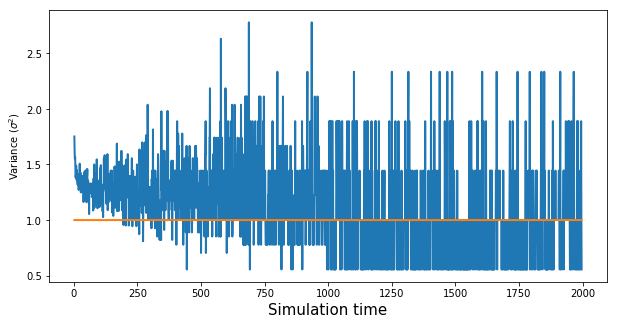

In [191]:
ess = EffectiveSampleSize(
    '/home/ishruna/Desktop/Research/REMD_ProtG/Strucutral_histogram/All_Data/all_data_truncated_pdb.pdb',
                          50, 5, 2, 10)
t, K, c, variance, fig = ess.analyze_variance()

the structural decorrelation time, τ, is 24 At subsampling interval 24 the variance first equals the theoretical prediction for i.i.d
Effective sample size is 17.5


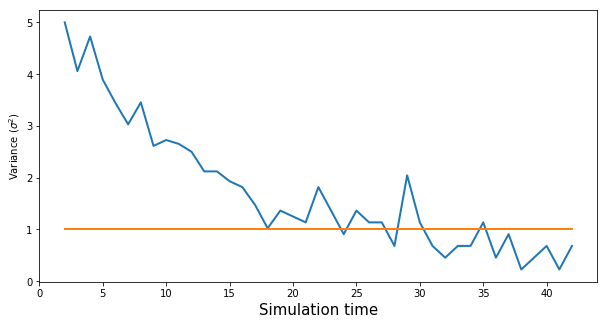

In [152]:
ess = EffectiveSampleSize('/home/ishruna/Desktop/Research/SA_Data/CMS_runs/SA_20ns/Run_1/Data/trajectory.pdb',
                          10, 2, 10)
t, K, c, variance, fig = ess.analyze_variance()

the structural decorrelation time, τ is 27. At subsampling interval 27 the variance first equals the theoretical prediction for i.i.d
Effective sample size is <__main__.EffectiveSampleSize object at 0x7f3079f814a8>


NameError: name 'unichr' is not defined